### Necessary Libraries

In [19]:
import hashlib
import csv
import random
import time
import threading
import hashlib
import concurrent.futures
import hashlib
import time
import matplotlib.pyplot as plt

### Function to Generate input file

The function generates an input file with the following structure:

- Each line starts with a user ID in the format `User_i`, where `i` is a random number ranging from 1 to 1 million.
- Following each user ID, there is a hash value of random number ranging from 1000 to 10000.

Here's an example section of the generated file: 
```
User_392253,74ed65a2d22a92c3b4e013c15ff04d05f4954cd792d9cf56e9a0edad5f914ed1
User_852766,5901aee4bc888df51bde5904a4c56d0a68536fb5157e19001973286ceed51354
User_513257,abbfc2b6da87b49139e8a13ce2ebf510818cfa6bc42e8cec990d36235dbb99bc
User_646094,c8ace20a55c88e4d1fc94009b763c6690efa764f5e6497cc736acf069b1fbc82
```

In [9]:
NUM_LINES = 1_000_000
MIN_VALUE_TO_HASH = 1
MAX_VALUE_TO_HASH = 1_000_000

In [11]:
def generate_input_file(file_name:str, num_lines, min_value_to_hash, max_value_to_hash):
    with open(file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Name', 'Hash Value'])  # set the first row of csv file which contains the headers of the colums
        for _ in range(num_lines):
            name = f'User_{random.randint(1, 1_000_000)}'
            num = random.randint(min_value_to_hash, max_value_to_hash)
            hash_value = hashlib.sha256(str(num).encode()).hexdigest()
            writer.writerow([name, hash_value])

# create source file
generate_input_file('source.csv', NUM_LINES, MIN_VALUE_TO_HASH, MAX_VALUE_TO_HASH)

### Function to break the hash values through a rainbow hacking method
This is what the whole project was about! A simple function to make a dictionary with `keys` being hash values of different numbers and the `values` being the corresponding number to each hash value.

It's worth pointing out that the algorithm used for hashing is the **SHA256 algorithm**.

In [12]:
def rainbow_password_hack(hashed_dict, input_file_name, output_file_name):
    
    for num in range(MIN_VALUE_TO_HASH, MAX_VALUE_TO_HASH + 1):
        hash_value = hashlib.sha256(str(num).encode()).hexdigest()
        hashed_dict[hash_value] = num
        
    with open(input_file_name, 'r') as input_file:
        next(input_file)  # skip the first line which is the header of the file
        lines = input_file.readlines()
        
    with open(output_file_name, 'w') as output_file:
        for line in lines:
            name, hash_value = line.strip().split(',')
            output_file.write(f"{name},{hashed_dict[hash_value]}\n")

In [14]:
hashed_dict_1 = {}
rainbow_password_hack(hashed_dict_1, 'source.csv', 'result.csv')

Now opening the `result.csv` file, you can see that the hash values are all broken and the initial numbers are all found!

> (The Following are ideas suggested by ChatGPT in order to improve the code and have a little fun with it! )


### Using Multithreading and Batch Proccesing

Batch processing is a method of executing tasks in a sequential manner without user interaction, commonly used for data processing and analysis. It offers several advantages such as improved efficiency, better resource management, non-interactive processing, data integrity, error handling, and scalability.

The provided code demonstrates a multithreaded approach to crack passwords using a dictionary of hashed passwords. It processes passwords in batches, enhancing efficiency by leveraging multiple threads to work on cracking passwords simultaneously. This approach allows for efficient resource utilization and is suitable for non-interactive batch processing tasks. The code maintains data integrity by processing well-defined batches and can be scaled by adjusting the batch size. While the code lacks explicit error handling, it can be extended to include appropriate mechanisms.

In [16]:
def rainbow_password_hack_multithreaded(hashed_dict, input_file_name, output_file_name):
    # function to process a batch of lines
    def process_batch(lines):
        for line in lines:
            name, hash_value = line.strip().split(',')
            output_file.write(f"{name},{hashed_dict[hash_value]}\n")
    
    # create a lock to synchronize access to the output file
    output_lock = threading.Lock()
    
    for num in range(MIN_VALUE_TO_HASH, MAX_VALUE_TO_HASH + 1):
        hash_value = hashlib.sha256(str(num).encode()).hexdigest()
        hashed_dict[hash_value] = num
        
    with open(input_file_name, 'r') as input_file, open(output_file_name, 'w') as output_file:
        next(input_file)  # skip the first line being the header of the file
        lines = input_file.readlines()
        
        # determine the batch size
        batch_size = 100  # one can adjust this value to find an optimal batch size
        
        # create a list to hold the thread objects
        threads = []
        
        for i in range(0, len(lines), batch_size):
            # create a thread for each batch of lines
            batch = lines[i:i+batch_size]
            t = threading.Thread(target=process_batch, args=(batch,))
            threads.append(t)
            t.start()
        
        # wait for all threads to finish
        for t in threads:
            t.join()

In [9]:
hashed_dict_2 = {}
start_time = time.time()
rainbow_password_hack_multithreaded(hashed_dict_2, 'source.csv', 'result.csv')
end_time = time.time()
print(f'It took {end_time - start_time} seconds to finish the task with multithreading')

It took 2.671334981918335 seconds to finish the task with multithreading


### Parallel Hashing
The presented code showcases a parallel approach for a rainbow password hack using multithreading and the `concurrent.futures` module. It efficiently cracks hashed passwords by dividing them into batches and processing them in parallel. The code populates a dictionary with hash values for a given number range and then reads an input file containing hashed passwords. It writes the cracked passwords to an output file. Key points to note are:

- Multithreading with `concurrent.futures` allows for parallel execution of tasks, enhancing performance.
- Batch processing optimizes the cracking process by dividing the passwords into smaller units for parallel processing.
- The code utilizes a thread pool executor to manage worker threads, with the number of threads determined by the num_threads parameter.
- Tasks are submitted to the executor using executor.submit() and completed using concurrent.futures.as_completed().
- Parallel processing offers benefits such as improved performance, efficient resource utilization, and scalability for larger password sets.

By implementing this code, one can efficiently crack hashed passwords in a parallel and scalable manner, making it suitable for large-scale password cracking tasks.

In [18]:
def rainbow_password_hack_parallel(hashed_dict, input_file_name, output_file_name, num_threads):
    for num in range(MIN_VALUE_TO_HASH, MAX_VALUE_TO_HASH + 1):
        hash_value = hashlib.sha256(str(num).encode()).hexdigest()
        hashed_dict[hash_value] = num

    with open(input_file_name, 'r') as input_file, open(output_file_name, 'w') as output_file:
        next(input_file)  # skip the first line being the header of the file
        lines = input_file.readlines()

        batch_size = 100
        num_lines = len(lines)
        num_batches = (num_lines + batch_size - 1) // batch_size

        with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
            # Submit tasks to the executor for parallel processing
            futures = []
            for i in range(0, num_lines, batch_size):
                batch = lines[i:i + batch_size]
                future = executor.submit(process_batch, batch, hashed_dict, output_file_name)
                futures.append(future)

            # Wait for all tasks to complete
            for future in concurrent.futures.as_completed(futures):
                # Retrieve the result of each task (if needed)
                result = future.result()

        # All tasks have completed at this point
        print("All tasks completed!")

def process_batch(lines, hashed_dict, output_file_name):
    with open(output_file_name, 'a') as output_file:
        for line in lines:
            name, hash_value = line.strip().split(',')
            output_file.write(f"{name},{hashed_dict[hash_value]}\n")

In [20]:
hashed_dict_3 = {}
start_time = time.time()
rainbow_password_hack_parallel(hashed_dict_3, 'source.csv', 'result.csv', 4)
end_time = time.time()
print(f'It took {end_time - start_time} seconds to finish the task with multithreading')

All tasks completed!
It took 2.7446000576019287 seconds to finish the task with multithreading


### A quick comparison of the time it takes for these 3 methods to prepare the `result.csv` file

All tasks completed!
All tasks completed!
All tasks completed!
All tasks completed!
All tasks completed!
All tasks completed!
All tasks completed!
All tasks completed!
All tasks completed!
All tasks completed!


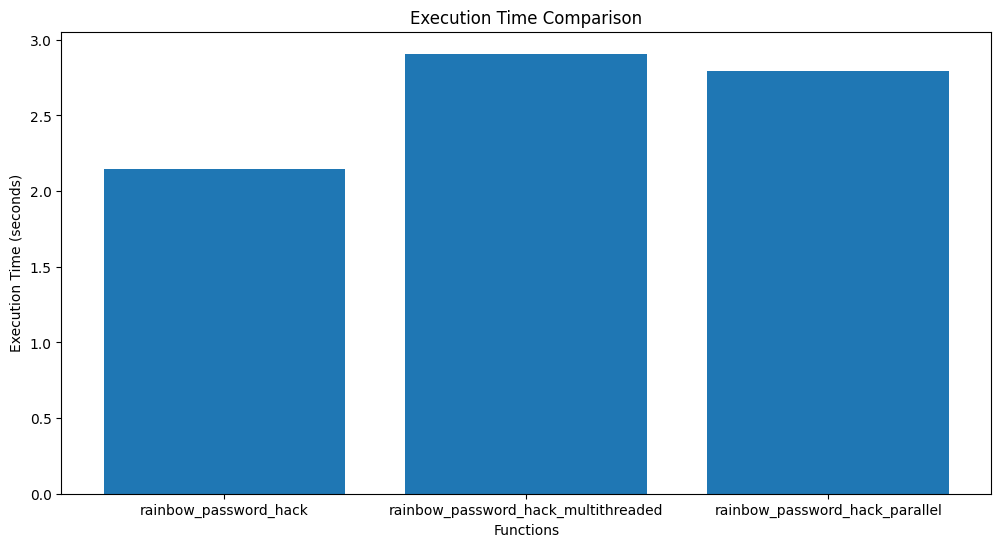

In [23]:
# Measure the execution time for each function
times = []
num_threads = 4  # Number of threads for parallel execution

# Function 1: rainbow_password_hack
time1 = 0
for _ in range(10):
    hashed_dict_1 = {}
    start_time = time.time()
    rainbow_password_hack(hashed_dict_1, 'source.csv', 'result.csv')
    end_time = time.time()
    time1 += (end_time - start_time) 
times.append(time1 / 10)

# Function 2: rainbow_password_hack_multithreaded
time2 = 0
for _ in range(10):
    hashed_dict_2 = {}
    start_time = time.time()
    rainbow_password_hack_multithreaded(hashed_dict_2, 'source.csv', 'result.csv')
    end_time = time.time()
    time2 += (end_time - start_time) 
times.append(time2 / 10)

# Function 3: rainbow_password_hack_parallel
time3 = 0
for _ in range(10):
    hashed_dict_3 = {}
    start_time = time.time()
    rainbow_password_hack_parallel(hashed_dict_3, 'source.csv', 'result.csv', 4)
    end_time = time.time()
    time3 += (end_time - start_time) 
times.append(time3 / 10)

# Plot the execution times
functions = ["rainbow_password_hack", "rainbow_password_hack_multithreaded", "rainbow_password_hack_parallel"]
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.bar(functions, times)
plt.xlabel("Functions")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time Comparison")
plt.show()